In [9]:
import cv2
from typing import Any
import subprocess
import os
from cv2.typing import MatLike
from argparse import ArgumentParser
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

def showim(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.show()

def show_images(images, cols = 1, titles = None, wspace=0.5, hspace=0.5, figsavename=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    if figsavename != None:
        plt.savefig(figsavename)
    plt.show()

color_list = [tuple(np.random.randint(0,255,3).tolist()) for j in range(100)]
def drawlines(img1,img2,lines,pts1,pts2):
 ''' img1 - image on which we draw the epilines for the points in img2
 lines - corresponding epilines '''
 r,c = img1.shape
 img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
 img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
 for i, (r,pt1,pt2) in enumerate(zip(lines,pts1,pts2)):
     color = color_list[i%len(color_list)]
     x0,y0 = map(int, [0, -r[2]/r[1] ])
     x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
     img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
     img1 = cv2.circle(img1,tuple(np.int32(pt1)),5,color,-1)
     img2 = cv2.circle(img2,tuple(np.int32(pt2)),5,color,-1)
 return img1,img2

def drawpoints(img1, pts1):
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    for i, pt in enumerate(pts1):
        color = color_list[i%len(color_list)]
        im1 = cv2.circle(img1, tuple(np.int32(pt)), 9, color, 3)
    return img1

(480, 640)
(480, 640)


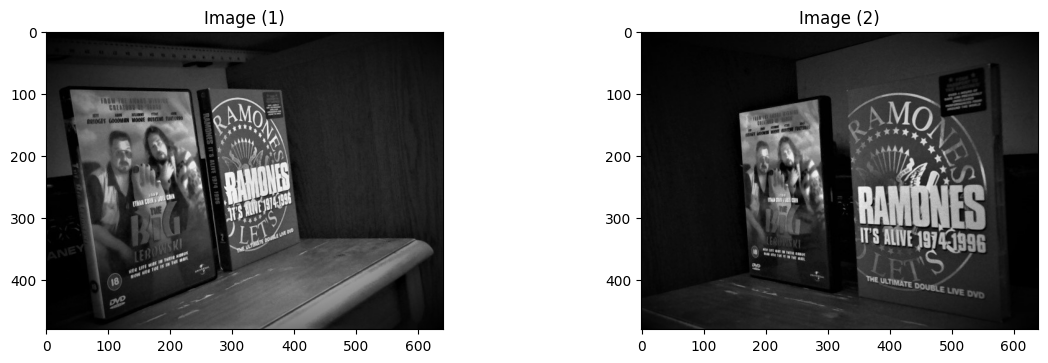

In [10]:
# img = cv2.imread('Kasuga_Lantern_(cross-eye_stereo_pair).jpeg')
# img = cv2.resize(img, dsize=(0,0), fx = .3, fy=.3)
# img_a = img[0:img.shape[0], 0:int(img.shape[1]/2)]
# img_b = img[0:img.shape[0], int(img.shape[1]/2): img.shape[1]]

# img_a = cv2.imread('i3.jpg')
# img_b = cv2.imread('i2.jpg')
# img_a = cv2.resize(img_a, dsize=(0,0), fx = .25, fy=.25)
# img_b = cv2.resize(img_b, dsize=(0,0), fx = .25, fy=.25)

img_a = cv2.imread('image_l.jpg')
img_b = cv2.imread('image_r.jpg')

img1 = cv2.cvtColor( img_a, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor( img_b, cv2.COLOR_BGR2GRAY)
print(img1.shape)
print(img2.shape)
show_images([img1, img2], cols=1)

# SIFT Keypoints

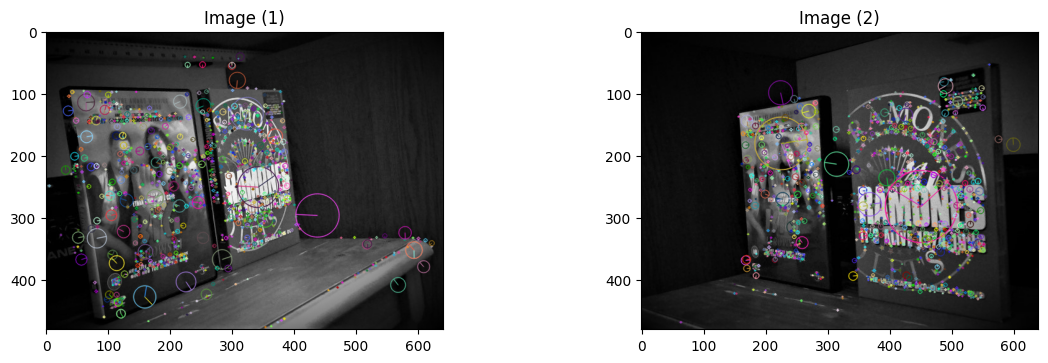

In [11]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kpimga = drawpoints(img1, [n.pt for n in kp1])
kpimgb = drawpoints(img2, [n.pt for n in kp2])

dkp = cv2.drawKeypoints(img1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
dkp2 = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

show_images([dkp, dkp2], cols=1)

# SIFT Keypoints + Brute Force Matcher (KNN Matching)

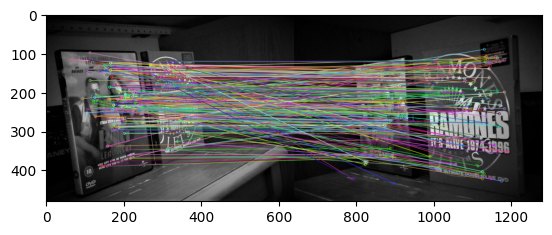

True

In [12]:
bf = cv2.BFMatcher(cv2.NORM_L1) # passing bool true as second arg cross checks
matches = bf.knnMatch(des1, des2, k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append((m,n))
im3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good, None, flags= cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

showim(im3)
cv2.imwrite("ReconstructionOut/SIFT_BRUTEKNN.png", im3)

# SIFT Keypoints + Brute Force Matcher (Single CrossCheck)

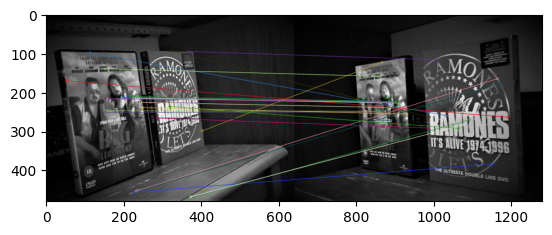

True

In [13]:
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True) # passing bool true as second arg cross checks
matches = bf.match(des1, des2)
matches = sorted(matches, key = lambda x:x.distance)
im3 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:25], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

showim(im3)
cv2.imwrite("ReconstructionOut/SIFT_BruteForceSingle.png", im3)

# SIFT Keypoints + FLANN Matching

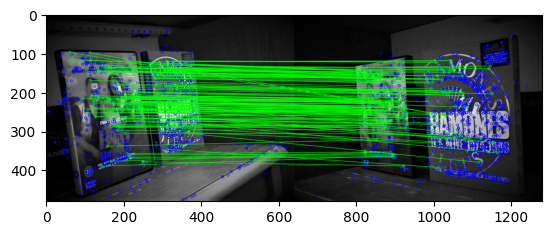

In [17]:
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary 
flann = cv2.FlannBasedMatcher(index_params,search_params) 
matches = flann.knnMatch(des1,des2,k=2) 
matchesMask = [[0,0] for i in range(len(matches))]

good = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        good.append((m,n))
 
draw_params = dict(matchColor = (0,255,0),
 singlePointColor = (255,0,0),
 matchesMask = matchesMask,
 flags = cv2.DrawMatchesFlags_DEFAULT)
 
im3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
showim(im3)

# ORB Keypoints

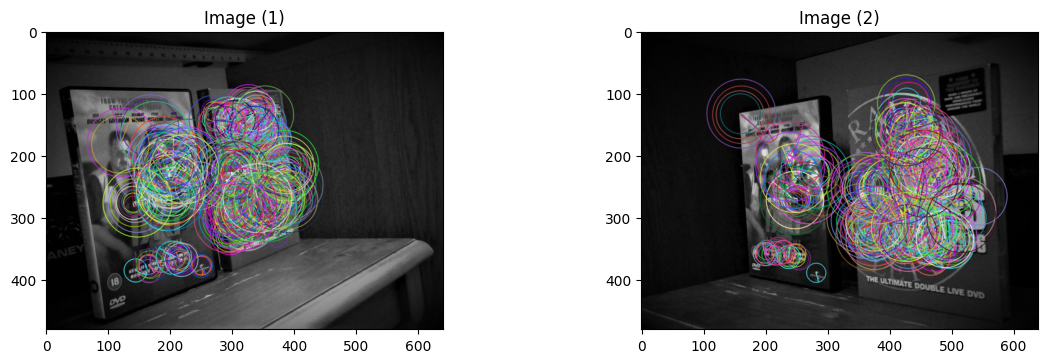

In [7]:
orb = cv2.ORB_create()

kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

dkp = cv2.drawKeypoints(img1, kp1, img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
dkp2 = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_images([dkp, dkp2], cols=1)

# ORB + BruteForce Single-Matching

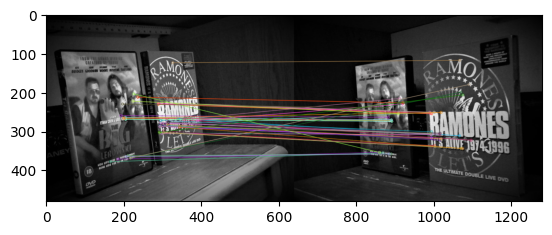

True

In [8]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
matches = bf.match(des1,des2) 
matches = sorted(matches, key = lambda x:x.distance) 
im3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
 
showim(im3)
cv2.imwrite("ReconstructionOut/ORB_BF_SINGLE.png", im3)

# ORB + FLANN Matching

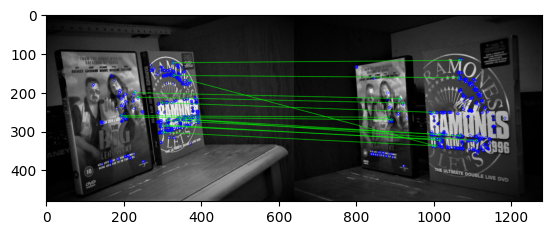

In [9]:
# FLANN parameters
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
 table_number = 6, # 12
 key_size = 12, # 20
 multi_probe_level = 1) #2
search_params = dict(checks=50) # or pass empty dictionary 
flann = cv2.FlannBasedMatcher(index_params,search_params) 
matches = flann.knnMatch(des1,des2,k=2) 

matchesMask = [[0,0] for i in range(len(matches))]
good = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        good.append((m,n))
 
draw_params = dict(matchColor = (0,255,0),
 singlePointColor = (255,0,0),
 matchesMask = matchesMask,
 flags = cv2.DrawMatchesFlags_DEFAULT)
 
im3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

showim(im3)

# Calculating FundamentalMatrix

matches: 148
matches in pts: 148 :: 148
[[ 2.90844228e-06  1.41929858e-05 -4.32131879e-03]
 [-3.34766459e-07 -7.20046385e-07 -5.76824091e-03]
 [ 4.63187425e-04  2.01416543e-03  1.00000000e+00]]


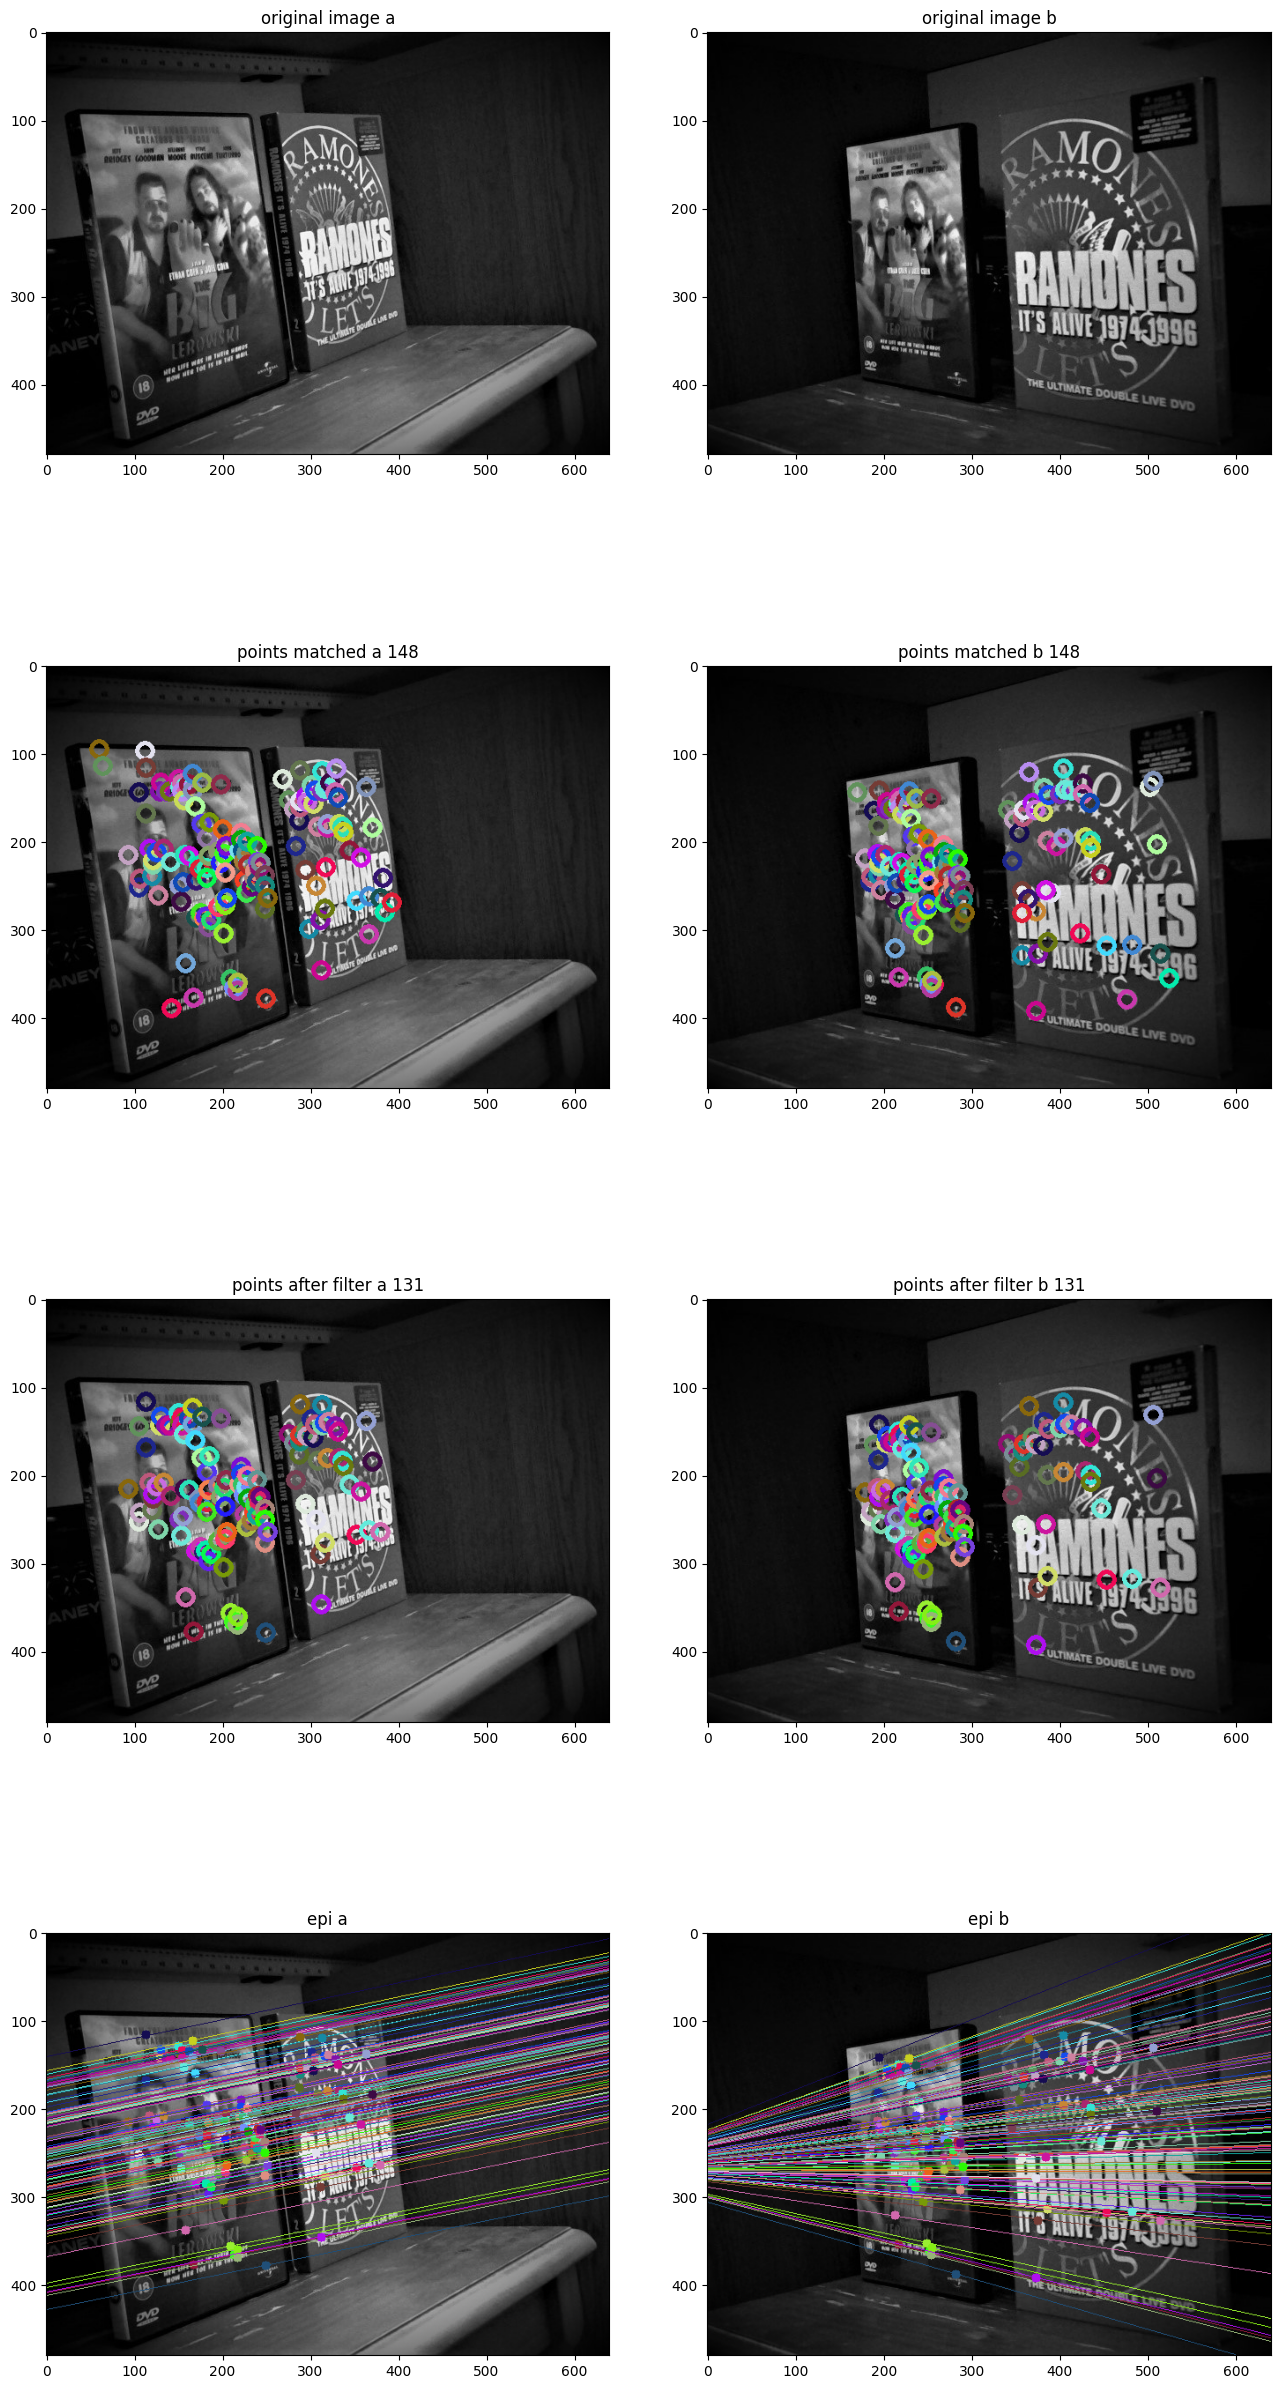

In [19]:
# SIFT + FLANN Matching above -> This (FM_LMEDS confidence =.999) nets good results, or at least similar to tutorial. Regardless there's a lot of tuning required. 

matches = good

pts1 = []
pts2 = []
print(f"matches: {len(matches)}")

inita = drawpoints(img1, [kp1[m.queryIdx].pt for (m,n) in matches])
initb = drawpoints(img2, [kp2[m.trainIdx].pt for (m,n) in matches])

for i, (m,n) in enumerate(matches):
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

print(f"matches in pts: {len(pts1)} :: {len(pts2)}")

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS, confidence=.999)
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img1_pts = drawpoints(img1, pts1)
img1_epi, _ = drawlines(img1, img2, lines1, pts1, pts2)

lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img2_pts = drawpoints(img2, pts2)
img2_epi, _ = drawlines(img2, img1, lines2, pts2, pts1)


print(F)
show_images([img1, img2, inita, initb, img1_pts, img2_pts, img1_epi, img2_epi],
            5,
            ["original image a", "original image b",
             f"points matched a {len([kp1[m.queryIdx].pt for (m,n) in matches])}", f"points matched b {len([kp2[m.trainIdx].pt for (m,n) in matches])}",
             f"points after filter a {len(pts1)}", f"points after filter b {len(pts2)}",
             "epi a", "epi b"], wspace=-.8, figsavename="controllerEpipolar.png")